In [1]:
# !pip install pydot


# !pip install tensorflow
# !pip uninstall -y keras tensorflow

# !pip install keras==2.15.0 tensorflow==2.15.0
# !pip show tensorflow keras


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers    import Lambda, Input, Dense
from tensorflow.keras.models    import Model
from tensorflow.keras.datasets  import mnist
from tensorflow.keras.losses    import mse, binary_crossentropy
from tensorflow.keras.utils     import plot_model
from tensorflow.keras           import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

/Users/niyaz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling 
        fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    # K is the keras backend
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [4]:
def first_plot(z,y_test):
    
    # os.makedirs(model_name, exist_ok=True)
    # filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    
    xmin = ymin = -4
    xmax = ymax = +4
    
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z       = z[0::2]
    y_test  = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    
    
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
        
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    # plt.savefig(filename)
    plt.show()

In [5]:
def second_plot(decoder):
    # filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            z_sample    = np.array([[xi, yi]])
            x_decoded   = decoder.predict(z_sample)
            digit       = x_decoded[0].reshape(digit_size, digit_size)
            
            figure[i * digit_size: (i + 1) * digit_size,   j * digit_size: (j + 1) * digit_size] = digit


    plt.figure(figsize=(10, 10))
    
    start_range = digit_size // 2
    end_range   = n * digit_size + start_range + 1
    
    # orignal source code [end_range-1] is [end_range] I added this [-1]
    pixel_range = np.arange(start_range, end_range-1, digit_size)
    
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    # plt.savefig(filename)
    plt.show()

In [6]:
def plot_results(models,data,batch_size=128,model_name="vae_mnist"):
    """Plots labels and MNIST digits as function 
        of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test , y_test  = data
    
    z, _, _ = encoder.predict(x_test,batch_size=batch_size)
     
    first_plot(z,y_test)
    second_plot(decoder)

In [7]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [8]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [9]:
# VAE model = encoder + decoder
# build encoder model
inputs      = Input(shape=input_shape, name='encoder_input')
x           = Dense(intermediate_dim, activation='relu')(inputs)
z_mean      = Dense(latent_dim, name='z_mean')(x)
z_log_var   = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary 
# with the TensorFlow backend
z = Lambda(sampling,output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [10]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# plot_model(encoder,to_file='vae_mlp_encoder.png',show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense[0][0]']               
                                                                                            

In [11]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [12]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder,to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [14]:
if __name__ == '__main__':
    
    
    parser = argparse.ArgumentParser()
    parser.add_argument("-w", "--weights", help="Load tf model trained weights")
    parser.add_argument("--bce", help="Use binary cross entropy instead of mse (default)", action='store_true')
    

    args, unknown = parser.parse_known_args()
    
    
    
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.bce:
        reconstruction_loss = binary_crossentropy(inputs,outputs)
    else:
        reconstruction_loss = mse(inputs, outputs)

    reconstruction_loss *= original_dim
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    
    # vae.summary()
    # plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

    save_dir = "vae_mlp_weights"
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    if args.weights:
        filepath = os.path.join(save_dir, args.weights)
        vae = vae.load_weights(filepath)
    else:
        # train the autoencoder
        vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
        filepath = os.path.join(save_dir, 'vae_mlp_mnist.tf')
        vae.save_weights(filepath)

Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 52.1597 - val_loss: 44.0838
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 43.5021 - val_loss: 42.5669
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 42.4168 - val_loss: 41.7770
Epoch 4/50
469/469 [==============================] - 3s 5ms/step - loss: 41.7577 - val_loss: 41.3302
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 41.2205 - val_loss: 40.8339
Epoch 6/50
469/469 [==============================] - 3s 5ms/step - loss: 40.8328 - val_loss: 40.5460
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 40.4914 - val_loss: 40.3499
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 40.2231 - val_loss: 40.0556
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 39.9832 - val_loss: 39.8257
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 39.7617

79/79 [==============================] - 0s 1ms/step


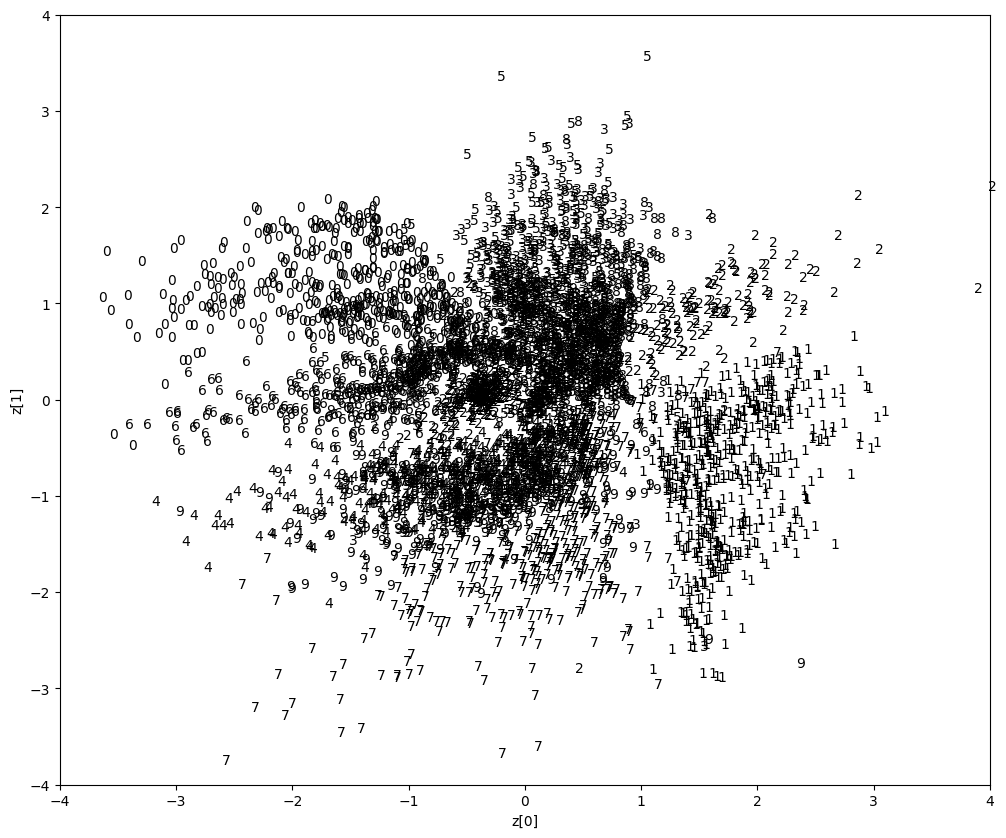

1/1 [==============================] - 0s 9ms/step


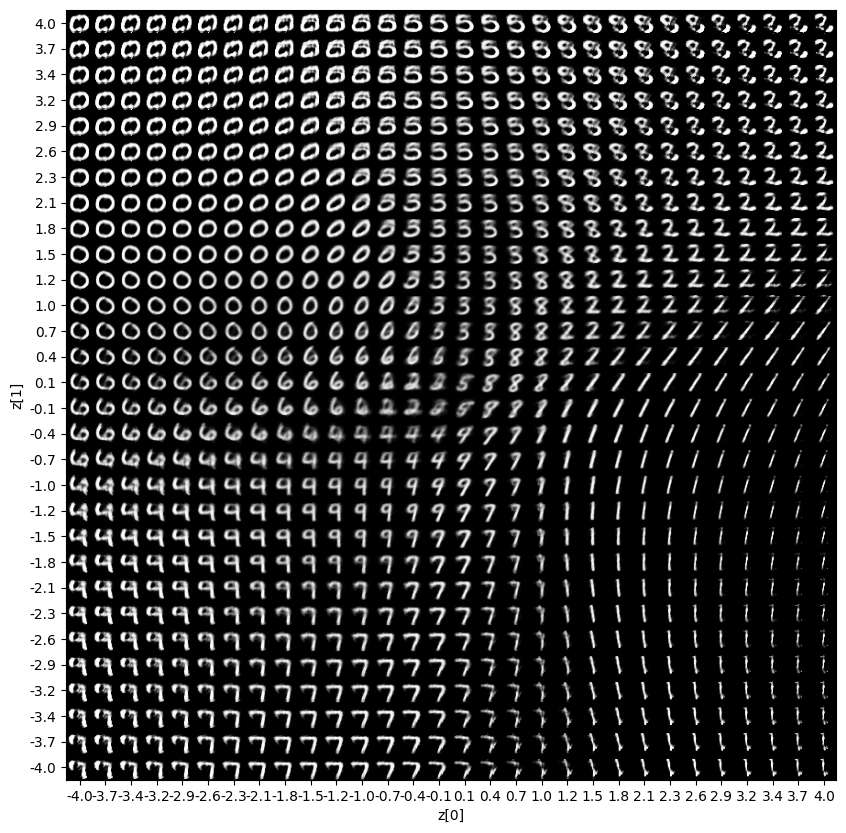

In [15]:
plot_results(models,data,batch_size=batch_size,model_name="vae_mlp")